# **TFM 2020**

## Integrantes:

- Cayetano Ortiz Nieto
- Pablo Benayas
- Arianna Santamaría
- Guillermo Fernandez

## Introducción:
Vidahorro es la primera app que te permite ir creando tu propio plan de pensiones privado mientras consumes. Con Vidahorro, cada vez que compres en nuestro marketplace con más de 150 empresas asociadas, acumularás hasta un 10% del importe de la compra, que el establecimiento cederá de forma gratuita a tu propio plan de pensiones privado. De forma que, cuanto más consumas, más capital acumularás para tu jubilación. Porque imagínate que acumularas el 5% de todo lo que consumes a lo largo de tu vida en tu propio plan de pensiones privado gestionado por una buena entidad, el capital que conseguirías acumular para tu jubilación sería superior a la pensión pública. A continuación se puede visualizar como funciona la aplicación: 

In [1]:
from IPython.display import HTML
HTML("""
<video width="500" height="300" controls>
  <source src="vidahorro_explicacion.mp4" type="video/mp4">
</video>
""")

Desde que lanzamos la app hace ya casi 2 años hemos hecho una fuerte inversión de capital para la captación de clientes a través de distintos canales de marketing. Como resultado, tenemos muchos usuarios procedentes de fuentes muy diversas: influencers, notas de prensa, Google Ads, Facebook Ads, anuncios de TV, Youtube Ads, entre otros. Algunos de estos usuarios que hemos captado serán activos y otros tantos no lo serán. ¿Pero cómo saberlo? Saber cuales serán activos y cuales no es fundamental para llevar a cabo un marketing eficiente de retención y activación. Porque para qué vamos a desperdiciar dinero en un usuario que el mes que viene no va a ser activo. O del revés para que invertir dinero en un usuario que ya se que existe una probabilidad muy alta de que sea activo.  

## Objetivo:
La clave del marketing eficiente radica en los puntos de corte, invertir en los usuarios que se encuentra en el límite entre ser activos y no serlos. De forma que, con una inversión razonable, no pierdas clientes que tanto dinero te han costado captar y formar en el funcionamiento de la app. 

En consecuencia, el objetivo de este trabajo será obtener las probabilidades para cada uno de los usuarios de que hagan click en una tienda a través de nuestro marketplace el próximo mes. Teniendo en cuenta estas probabilidades individuales, lo que la empresa ya puede hacer, es segmentar estos clientes en diferentes grupos. Por ejemplo, vamos a descartar a todos los clientes que tengan una probabilidad menor del 40% ya que el coste de convertirlos en activos es demasiado alto; y también vamos a descartar a todos aquellos usuarios que tengan una probabilidad superior al 80% de hacer click, ya que sería en muchos casos tirar el dinero porque ya son usuarios con una alta probabilidad; y nos vamos a centrar en hacer una campaña de marketing a los usuarios cuyas probabilidades estén entre el 40% y el 80%, y dentro de este grupo ajustaremos la distribución del presupuesto en función de las probabilidades.

## Método:
- Estos son los métodos usados para cada una de las partes:
  - El análisis exploratorio de datos es realizado con el paquete Sweetviz y una función creada manualmente.
  - El procesamiento de datos es llevado a cabo con pipelines. Para ello, se han construido funciones especializadas en limpiar variables con problemas concretos.
    - Estas funciones irán encadenadas en un pipeline que devolverá el fichero limpio y listo para la parte de modelaje.
  - En la parte de modelaje se usarán varios algorítmos, se hará una búsqueda de hiper parámetros (para encontrar la mejor combinación) y se elegirá el modelo ganadar en función de una métrica que se comentará más adelante.
  - Finalmente, se creará una aplicación con el paquete 'tkinter'. Se trata de una Interfaz gráfica de usuario que permite cargar ficheros, procesarlos y devolver en un archivo excel la probabilidad de que cada usuario sea activo en el siguiente mes.

¡Empecemos!

## Parte I: Importación

### 1) Se importan todas las librerías que se van a utilizar.

In [2]:
!pip install sweetviz
!pip install fuzzywuzzy
!pip install requests
!pip install bs4
!pip install lxml

In [3]:
!pip install beautifulsoup4

In [4]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt

from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from datetime import date
from sklearn.model_selection import cross_val_score
from tkinter import *
from tkinter import filedialog 
from tkinter import messagebox as msg
from tkinter import simpledialog
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve, make_scorer, classification_report
from sklearn.linear_model import LogisticRegression
import itertools 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import unicodedata
from fuzzywuzzy import process
import sweetviz
import warnings
warnings.filterwarnings("ignore")

from tkinter import *
import tkinter as tk
from tkinter import filedialog 
from tkinter import messagebox as msg
from tkinter import simpledialog
from tkinter import PhotoImage
import os
import requests
from bs4 import BeautifulSoup 

from IPython.display import HTML
import lxml

### 2) Crear fichero:

- Se crea una función que permite convertir las rutas en 'dataframes' de 'pandas'.

- Se crea una función que fusiona los ficheros en un único fichero.

- La función 'analytics' nos permite comparar el número de NaNs, número de valores únicos y el tipo de cada una de las variables del fichero.

In [5]:
#LECTURA DE ARCHIVOS Y MERGE
def leer_ficheros(lista_de_rutas): #ejemplo de argumento -> ['data_x.csv', 'data_y.xlsx', ...]
  dict_rutas = {}
  for ruta in lista_de_rutas:
    ruta = re.findall(r'[a-z_.]+', ruta.lower())[0]         
    if len(re.findall(r'.csv', ruta)) > 0 :
      dict_rutas[re.findall(r'^[a-z_]*', ruta)[0]] = pd.read_csv(ruta, sep = ';')
    if len(re.findall(r'xlsx', ruta)) > 0 :
      dict_rutas[re.findall(r'^[a-z_]*', ruta)[0]] = pd.read_excel(ruta)

  return dict_rutas


dataframes = leer_ficheros(['usuarios.xlsx', 'no_boletin_adhesion.xlsx', 'no_dni.xlsx', 'programas.xlsx']) #'aportaciones.xlsx'

def merge_datasets(df1, df2 = dataframes['programas'], df3 = dataframes['no_dni'], df4 = dataframes['no_boletin_adhesion']): #dfs son dataframes
  if 'no_boletin' not in df4.columns:
    df4.insert(1,'no_boletin', 0)
    df3.insert(1,'no_dni', 0)
  
  result_1=pd.merge(df1, df2, on='Id', how='left')
  result_2=pd.merge(result_1, df3, on='Id', how='left')
  result_3=pd.merge(result_2, df4, on='Id', how='left')
  return result_3


def analytics(dataframe):
  unique= list(pd.DataFrame(dataframe.columns, index=dataframe.columns).apply(lambda x: len(dataframe[x[0]].unique()), axis=1))
  analytics = pd.DataFrame({'Tipo':dataframe.dtypes, 'NAs':dataframe.isnull().sum(), 'Valores únicos':unique})
  return analytics


  
result_4 = (dataframes['usuarios'].pipe(merge_datasets))
print('El fichero tiene {} filas y {} columnas.'.format(result_4.shape[0], result_4.shape[1]))  
print('\n')
analytics(result_4)

El fichero tiene 4239 filas y 19 columnas.




Tipo   NAs  Valores únicos
Id                      int64     0            4239
Sexo                   object     0               2
Estado civil           object     0               5
F. Nacimiento          object    20            3559
CPO                    object    38            1715
Localidad              object    14            1566
Provincia              object    28             215
Profesión              object    15            1295
Res. Fiscal            object     0              31
Fecha alta             object     0             628
Cod. Promoción         object  2269             223
Fecha baja             object  4199              36
Motivo baja            object  4199               7
Publicidad Vidahorro    int64     0               2
Publicidad terceros     int64     0               2
Programa 1             object  3505               2
Programa 2             object  4180               3
no_dni                float64  1775               2
no_boletin            float64  1199               2

## Parte II: EDA con el paquete SweetViz

### 1) Crear informe de Análisis Exploratorio de Datos

In [6]:
informe = sweetviz.analyze([result_4, 'Ficheros fusionados'])

:FEATURES DONE:                    |█████████████████████| [100%]   00:04  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!


### 2) Visualización en html


In [7]:
informe.show_html('Informe_Analisis_Exploratorio_de_datos.html')

Report Informe_Analisis_Exploratorio_de_datos.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


## Parte III: Conclusiones tras el análisis exploratorio y limpieza de variables:

### 1) Renombrar columnas

Para evitar posibles problemas con el nombre de las variables, eliminamos espacios en blanco y signos de puntuación:

In [8]:
def rename_cols(df): # En el pipeline que crearemos a continuación está función va seguida de 'merge_datasets(...)'. Por tanto, el dataframe
                     # que recibirá será el resultado de tal función (en este caso, el dataframe llamado 'result_3')
  df_renamed_cols = df.rename(columns={"Cod. Promoción": "cod_promo", 
                                      "Programa 1": "program_1", 
                                      "Programa 2":"program_2", 
                                      "Estado civil":"estado_civil", 
                                      "Motivo baja":"motivo_baja", 
                                      "Fecha baja":"fecha_baja", 
                                      "Res. Fiscal":"res_fiscal"})
  return df_renamed_cols

### 2) Imputación de valores NaN:

- Las columnas 'no_boletin' y 'no_dni' tienes dos posibles valores: NaN y 0. Por tanto, los NaN se convierten en 1 (el usuario sí tiene boletín/dni).

- Las columnas 'Fecha baja' y 'Motivo baja' son eliminadas porque se prentende analizar a los usuarios que siguen activos para, posteriormente, predecir si serán usuarios activos en el futuro.

- La columna 'cod_promo' es convertida a binaria: 1 si tiene algún tipo de código promocional y 0 en caso contrario. Para ello, se convierte la categoría 'sin_promo' a cero y el resto de categorías distintas a cero, se convierten en 1.

- Las columnas 'program_1' y 'program_2' tienen dos categorías: el nombre de la empresa que lanza el programa y el valor NaN. Por tanto, sustituimos el nombre por 1 y la categoría NaN por 0

In [9]:
def imputacion_de_valores_desconocidos(dataframe):
  dataframe['no_dni'] = dataframe['no_dni'].fillna(1) # 1 si tiene DNI.
  
  dataframe['no_boletin'] = dataframe['no_boletin'].fillna(1) # 1 si tiene boletín.
  
  dataframe.drop('fecha_baja', axis=1, inplace=True)
  dataframe.drop('motivo_baja', axis=1, inplace=True)

  dataframe['cod_promo'] = dataframe['cod_promo'].fillna(0) # 0 si no tiene código promocional.
  dataframe.cod_promo.replace(('sin promo'),(0), inplace=True) # 0 si no tiene código promocional.
  dataframe.cod_promo.replace(('No'),(0), inplace=True) # 0 si dice que no es 0
  dataframe['cod_promo'][dataframe['cod_promo'] != 0] = 1

  dataframe['program_1'] = dataframe['program_1'].fillna(0) # 0 si no tiene programa Cepsa.
  dataframe.program_1.replace(('Cepsa'),(1), inplace=True) # 1 si tiene programa Cepsa.

  dataframe.program_2.replace(('VidahorroCard', 'Unielectrica'),(1), inplace=True) # 1 si tiene programa VidahorroCard.
  dataframe['program_2'] = dataframe['program_2'].fillna(0) # 0 si no tiene programa 'VidahorroCard' o 'Unielectrica'.

  return dataframe 

### 3) Variable Sexo:

- Se trata de una variable categórica con dos categorías: 'Hombre' y 'Mujer'.
La variable se convierte a binaria con la función 'get_dummies' del paquete pandas. 

- IMPORTANTE: para evitar futuros problemas de multicolinearidad, elimino una de las dummies que genera con el argumento 'drop_first = True'.

In [10]:
def variable_sexo(dataframe):
  sexo_dummies = pd.get_dummies(dataframe['Sexo'], drop_first = True)
  dataframe["mujer"]=sexo_dummies
  dataframe.drop('Sexo', axis=1, inplace=True)
  return dataframe 

### 4) Variable estado_civil:

- Se unifica 'Soltero' y 'Soltera' en una única categoría.

- Mismo proceso que con la variable Sexo.

In [11]:
def estado_civil(dataframe):
  dataframe.estado_civil.replace(('Soltera'),('Soltero'), inplace=True)
  estado_civil = pd.get_dummies(dataframe['estado_civil'], drop_first = True)
  estado_civil['Id'] = dataframe.Id 
  dataframe = pd.merge(dataframe, estado_civil, on='Id', how='left')
  return dataframe

### 5) Variable Fecha alta:

- Se crea una nueva variable que recoja el número de días desde la fecha de alta hasta la fecha actual.

- Una vez creada esta nueva variable, se procede a eliminar 'Fecha alta'.

In [12]:
def fecha_de_alta(dataframe):
  string_today = str(date.today().day)+'/'+str(date.today().month)+'/'+str(date.today().year) 
  timestamp_today = datetime.timestamp(datetime.strptime(string_today, '%d/%m/%Y'))
  dataframe['Fecha alta'] = dataframe['Fecha alta'].apply(lambda x: datetime\
                                                        .fromtimestamp(timestamp_today) - datetime.\
                                                        fromtimestamp(datetime.timestamp(datetime.strptime(x, '%d/%m/%Y'))))
  dataframe['dias_desde_fecha_alta'] = dataframe['Fecha alta'].apply(lambda element: int(str(element)[:str(element).index('d')-1]))
  dataframe.drop('Fecha alta', axis=1, inplace=True)
  return dataframe

### 6) Residencia fiscal:

- Al ser un campo abierto, las personas ingresaron diferentes respuestas. La inmensa mayoría (99.881 %), aunque de forma distinta (especificando nombre de provincia/ localidad/ CCAA españolas), indicaron que su residencia fiscal es España. 

- Por tanto, esta variable no es útil para futuros modelos y es eliminada.

In [13]:
def residencia_fiscal(dataframe):
  dataframe.drop('res_fiscal', axis=1, inplace=True)
  return dataframe 

### 7) Fecha de Nacimiento:

- Con la variable fecha de Nacimiento calculamos la edad en años de los usuarios.

In [14]:
def calcular_edad_con_fecha_nacimiento(dataframe):
  no_nulls = pd.to_datetime(dataframe.loc[~dataframe['F. Nacimiento'].isnull(),'F. Nacimiento'], format='%d/%m/%Y') 
  mean_age = no_nulls.mean().year 
  dataframe.loc[~dataframe['F. Nacimiento'].isnull(),'F. Nacimiento'] = no_nulls.apply(lambda date: date.year)
  dataframe.loc[dataframe['F. Nacimiento'].isnull(),'F. Nacimiento'] = mean_age
  dataframe['edad'] = date.today().year - dataframe['F. Nacimiento']
  dataframe['edad'] = dataframe['edad'].apply(lambda x: int(x))
  return dataframe

### 8) Código Postal:

- En el html del análisis exploratorio de los datos se observa que 'CPO' es una variable númerica. Sin embargo, es tratada como categórica. 

- Al hacer una expresión regular que identifica las letras dentro de una cadena de caracteres, se encuentra que hay dos valores que contienen letras. Se sustituye la letra por el dígito '0'. Finalmente, se convierte esta variable tipo numérica.

- Además, se puede obsevar que los dos primeros dígitos del código postal corresponde a la provincia. Con este descubrimiento se agrupo los valores en 4 categorías: 'Norte_España', 'Este_España', 'Madrid' y 'Sur_España'.

- Una vez hecha la agrupación, se procede a usar la función de 'pandas' 'get_dummies'. Teniendo en cuenta que, para evitar la multicolinearidad, se ha de eliminar una de las 'dummies' creada.

In [15]:
def codigo_postal(dataframe):
  index_positon_element_with_chars = dataframe.CPO[~dataframe.CPO.isnull()][dataframe.CPO[~dataframe.CPO.isnull()]\
                                                                            .apply(lambda element: len(re.findall('[A-Za-z]+', element))>0)].index
  dataframe.CPO[index_positon_element_with_chars] = [46010, 18210]
  dataframe.CPO[~dataframe.CPO.isnull()] = dataframe.CPO[~dataframe.CPO.isnull()].apply(lambda element: int(element))
  dataframe.CPO[dataframe.CPO.isnull()] = dataframe.CPO[~dataframe.CPO.isnull()].median()
  dataframe.CPO = dataframe.CPO.apply(lambda x: int(x))
  
  dataframe['CPO_transformation'] = dataframe.CPO
  dataframe['CPO_transformation'] = dataframe['CPO_transformation'].apply(lambda x: str(x))
  dataframe['CPO_transformation'] = dataframe['CPO_transformation'].str.slice(0,2)
  dataframe['CPO_transformation'] = dataframe['CPO_transformation'].fillna('00')

  dataframe['CPO_transformation'] = dataframe.CPO_transformation.fillna('00')
  grupos = {'Norte_España': #NORTE DE ESPAÑA (Galicia, Asturias, Cantabria, País Vasco, Navarra, Castilla Leon)
             ['01','05','09','15','20','21','24','27','31','32','33','34','36','37','39','40','42','47','48','49'],
             'Este_España': #ESTE DE ESPAÑA (La Rioja, Aragon, Cataluña, C.Valenciana, Baleares)
             ['03','07','08','12','17','22','25','26','43','44','46','50'],
             'Madrid': #MADRID
             ['28','00'],
             'Sur_España': #SUR DE ESPAÑA (Castilla La Mancha, Extremadura, Andalucia, Murcia, Canarias, Ceuta y Melilla)
             ['02','04','06','10','11','13','14','16','18','19','21','23','29','30','35','38','41','45','51','52']}

  grupos_cpo = {}
  for key, value in grupos.items():
      for prov in value:
          grupos_cpo[prov]=key

  dataframe['CPO_transformation'] = dataframe.CPO_transformation.map(grupos_cpo)
  CPO_dummies = pd.get_dummies(dataframe['CPO_transformation'], drop_first = True)
  CPO_dummies['Id'] = dataframe.Id 
  dataframe = pd.merge(dataframe, CPO_dummies, on='Id', how='left')
  dataframe.drop('CPO_transformation', axis=1, inplace=True)
  return dataframe

### 9) ¿Qué sucede con las variables 'Localidad', 'Provincia' y 'Profesión?

- Estas 3 variables, al ser de tipo texto, requieren una limpieza más exhaustiva.

- Para no comprometer la extensión del jupyter notebook, se procede a incluir la limpieza de dichas variables en el anexo.

## Parte IV: Fichero 'clicks.csv':

- En este fichero se recogen los clicks que cada usuario ha hecho durante varios meses consecutivos.

### 1) EDA del fichero 'clicks' con el paquete SweetViz

- 'leer_ficheros(['clicks.csv'])' devuelve un diccionario con clave 'clicks' y como valor el fichero en sí. 

- 'leer_ficheros' es una función creada en el apartado 'Crear fichero'.

- Una vez que se tiene el fichero como 'pandas dataframe', se procede a usar el paquete 'sweetviz' para generar el análisis exploratorio en html.

In [16]:
# 'leer_ficheros(['clicks.csv'])' devuelve un diccionario con clave 'clicks' y valor el fichero clicks abierto como dataframe de pandas
clicks = leer_ficheros(['clicks.xlsx']) 
clicks = clicks['clicks']
clicks['nombre_partner'] = clicks['nombre_partner'].astype(str) 

informe_clicks = sweetviz.analyze([clicks, 'clicks'])
informe_clicks.show_html('Informe_Analisis_Exploratorio_clicks.html')

:FEATURES DONE:                    |█████████████████████| [100%]   00:02  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!
Report Informe_Analisis_Exploratorio_clicks.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


### 2) Limpieza de variables:

- Se crea una función que identifica el último día del mes. Esta función será usada posteriormente.

- La variable 'fecha' del fichero 'clicks.csv' se codifica a formato fecha con la función 'to_datetime' de 'pandas'. Una vez en formato fecha, se extrae el mes y el año de la misma.

In [17]:
# 'fechas(leer_ficheros(['clicks.csv'])['clicks'])' equivale a: 'fechas(clicks)'
  
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + timedelta(days=4)  # this will never fail
    return next_month - timedelta(days=next_month.day)


def fechas(dataframe):
  dataframe['fecha'] = pd.to_datetime(dataframe['fechaClick'], format='%Y-%m-%d %H:%M:%S') # https://www.journaldev.com/23365/python-string-to-datetime-strptime
  dataframe['fecha2'] = dataframe['fecha'].dt.date
  dataframe['fechaClick_month'] = dataframe['fecha'].apply(lambda date: date.month) 
  dataframe['fechaClick_year'] = dataframe['fecha'].apply(lambda date: date.year)
  return dataframe

### 3) Feature engineering para el dataset de clicks.

- El objetivo es que no se repita el idUsuario tantas veces como clicks realizados. Para ello, se va agrupar el fichero por IdUsuario y se van a realizar las siguientes métricas.

    - Número de clicks por usuario.
    - Promedio de clicks por mes.
    - Días desde el primer al último click
    - Días desde el primer al último click dividido por el número total de clicks realizados por el usuario.
    - Días desde la última fecha donde se recojen las métricas hasta el último click realizado por el usuario.

In [18]:
def metrics(beginning_date, ending_date, dataframe = fechas(leer_ficheros(['clicks.xlsx'])['clicks'])): #Example -> metrics('2020-01-01', '2020-02-29')

  clicks_for_metrics = dataframe.loc[(dataframe.fecha2 >= beginning_date) & (dataframe.fecha2 <= ending_date),:]

  grouped = clicks_for_metrics.groupby(['idUsuario','fechaClick_year','fechaClick_month'])

  count_clicks = grouped.count().loc[:,'idClicks']
  count_clicks.columns = 'count_clicks' #DF con clicks por usuario, mes y año

  promedio_clicks_por_mes = count_clicks.groupby('idUsuario').mean()

  min_max_dates_by_user = clicks_for_metrics.groupby('idUsuario').agg({'fecha2':['min','max']})
  min_max_dates_by_user.columns =  ['min','max']
  min_max_dates_by_user['min'] = pd.to_datetime(min_max_dates_by_user['min'],format='%Y-%m-%d')
  min_max_dates_by_user['max'] = pd.to_datetime(min_max_dates_by_user['max'],format='%Y-%m-%d')  
  min_max_dates_by_user['min'] = min_max_dates_by_user['min'].dt.date
  min_max_dates_by_user['max'] = min_max_dates_by_user['max'].dt.date
  dias_desde_primer_a_ultimo_click = (min_max_dates_by_user['max'] - min_max_dates_by_user['min']).dt.days

  clicks_por_usuario = clicks_for_metrics.groupby('idUsuario').count().iloc[:,0]
  
  clicks_insights = pd.DataFrame({'clicks_por_usuario': clicks_por_usuario, 'promedio_clicks_por_mes':promedio_clicks_por_mes,
                                  'dias_desde_primer_a_ultimo_click': dias_desde_primer_a_ultimo_click})

  clicks_insights['dias_ultimo_primer_sobre_total_clicks'] = clicks_insights.apply(lambda x: x[2]/x[0], axis =1)
  clicks_insights['dias_desde_ultimo_click'] = (ending_date - min_max_dates_by_user['max'])
  clicks_insights['dias_desde_ultimo_click'] = clicks_insights['dias_desde_ultimo_click'].dt.days
  return clicks_insights

## Parte V: Definir la variable objetivo y fusionar los dos datasets creados:

- El primer dataset contiene principalmente las variables demográficas de cada usuario.
- El fichero de 'clicks', por el contrario, contiene métricas de los clicks realizados por cada usuario.

### 1) Definir variable objetivo con fichero clicks y añadir fichero con las variables demográficas:

- Variable objetivo:

  -Si un usuario hizo click en alguna tienda en el mes en cuestión, es activo (1), sino (0). 

- Se usarán los meses de marzo y abril como train y test. 

- la función 'merge' de 'pandas' nos permite fusionar los ficheros. Hay que especificar que la columna 'Id' del fichero demográfico equivale a la columna 'idUsuario' del fichero clicks.

- Se añaden las columnas adicionales, creadas con la función 'metrics'. Dado que es posible que no todos los usuarios estén incluidos en el fichero que devuelve 'metrics', se proceder a imputar los valores NaN con 0.

In [19]:
# función train y test
def mes_anterior_y_mes(dataframe_clicks, dataframe_demographics, mes_resultados = 4, mes_anterior = 3):
  usuarios_mes = dataframe_clicks.loc[(dataframe_clicks.fechaClick_year == 2020) & (dataframe_clicks.fechaClick_month == mes_resultados)]
  usuarios_mes = usuarios_mes.groupby(['idUsuario']).count()
  usuarios_mes = usuarios_mes.reset_index()
  usuarios_mes = usuarios_mes.iloc[:,0:2]
  usuarios_mes = usuarios_mes.rename(columns={"idClicks": "n_clicks"})
  usuarios_mes.insert(1,'activo', 1)
  usuarios_mes_anterior = dataframe_clicks.loc[(dataframe_clicks.fechaClick_year == 2020) & (dataframe_clicks.fechaClick_month == mes_anterior)]
  usuarios_mes_anterior = usuarios_mes_anterior.groupby(['idUsuario']).count()
  usuarios_mes_anterior = usuarios_mes_anterior.reset_index()
  usuarios_mes_anterior = usuarios_mes_anterior.iloc[:,0:2]
  usuarios_mes_anterior = usuarios_mes_anterior.rename(columns={"idClicks": "n_clicks"})
  usuarios_mes_anterior.insert(1,'activo', 1)

  df_mes=pd.merge(dataframe_demographics, usuarios_mes, how='left', left_on=['Id'], right_on=['idUsuario'])
  df_mes['activo'] = df_mes['activo'].fillna(0)
  df_mes['n_clicks'] = df_mes['n_clicks'].fillna(0)

  df_mes_anterior=pd.merge(dataframe_demographics, usuarios_mes_anterior, how='left', left_on=['Id'], right_on=['idUsuario'])
  df_mes_anterior['activo'] = df_mes_anterior['activo'].fillna(0)
  df_mes_anterior['n_clicks'] = df_mes_anterior['n_clicks'].fillna(0)
  metrics_mes = metrics(date(2020,1,1), last_day_of_month(date(2020,mes_resultados,1)))
  metrics_mes_anterior = metrics(date(2020,1,1), last_day_of_month(date(2020,mes_anterior,1)))
  df_mes = pd.merge(df_mes, metrics_mes, left_on='Id', right_on='idUsuario', how='left')

  df_mes['clicks_por_usuario'] = df_mes['clicks_por_usuario'].fillna(0)
  df_mes['promedio_clicks_por_mes'] = df_mes['promedio_clicks_por_mes'].fillna(0)
  df_mes['dias_desde_primer_a_ultimo_click'] = df_mes['dias_desde_primer_a_ultimo_click'].fillna(0)
  df_mes['dias_ultimo_primer_sobre_total_clicks'] = df_mes['dias_ultimo_primer_sobre_total_clicks'].fillna(0)
  df_mes['dias_desde_ultimo_click'] = df_mes['dias_desde_ultimo_click'].fillna(0)

  df_mes_anterior = pd.merge(df_mes_anterior, metrics_mes_anterior, left_on='Id', right_on='idUsuario', how='left')

  df_mes_anterior['clicks_por_usuario'] = df_mes_anterior['clicks_por_usuario'].fillna(0)
  df_mes_anterior['promedio_clicks_por_mes'] = df_mes_anterior['promedio_clicks_por_mes'].fillna(0)
  df_mes_anterior['dias_desde_primer_a_ultimo_click'] = df_mes_anterior['dias_desde_primer_a_ultimo_click'].fillna(0)
  df_mes_anterior['dias_ultimo_primer_sobre_total_clicks'] = df_mes_anterior['dias_ultimo_primer_sobre_total_clicks'].fillna(0)
  df_mes_anterior['dias_desde_ultimo_click'] = df_mes_anterior['dias_desde_ultimo_click'].fillna(0) 

  return df_mes_anterior, df_mes 

### 2) X_train, X_test, y_train, y_test

- Una vez que la variable objetivo es creada y el resto de variables se encuentran en un único fichero para los datos de entrenamiento y test, se procede a crear X_train, X_test, y_train, y_test.

In [20]:
def train_test_split(train, test):

  variables = list(test)
  tiposvar = dict(test.dtypes)
  decimal = [x for x in variables if tiposvar[x]=='float64']
  enteros = [x for x in variables if tiposvar[x]=='int64']
  otros = [x for x in variables if tiposvar[x]=='uint8']
  numericas = decimal + enteros + otros
  numericas.remove('activo')
  numericas.remove('n_clicks')
  numericas.remove('idUsuario')

  X_train = train[numericas]
  X_test = test[numericas]


  X_train = StandardScaler().fit_transform(X_train) # si creamos  pipeline, ya nos lo hace automáticamente
  y_train = train['activo']
  X_test = StandardScaler().fit_transform(X_test) # si creamos  pipeline, ya nos lo hace automáticamente
  y_test = test['activo']

  return X_train, X_test, y_train, y_test

## Parte VI: Pipeline con las funciones que han sido creadas

- En esta celda llamamos a las funciones que hemos ido creando previamente:

  - Comienza con la función que lee las rutas de los archivos y acaba con la función que devuelve 'X_train, X_test, y_train, y_test'.

  - Pasando por todos los pasos intermedios.

- La principal ventaja de usar pipelines es que se puede usar para ficheros con datos de nuevos meses, sin haber cambiado una línea de código.

In [21]:
dataframes = leer_ficheros(['usuarios.xlsx', 'no_boletin_adhesion.xlsx', 'no_dni.xlsx', 'programas.xlsx', 'clicks.xlsx'])  

result_4 = (dataframes['usuarios'].pipe(merge_datasets)
                  .pipe(rename_cols)
                  .pipe(imputacion_de_valores_desconocidos)
                  .pipe(variable_sexo)
                  .pipe(estado_civil)
                  .pipe(fecha_de_alta)
                  .pipe(residencia_fiscal)
                  .pipe(calcular_edad_con_fecha_nacimiento)
                  .pipe(codigo_postal)
           ) 


train, test = (dataframes['clicks'].pipe(fechas)
                                   .pipe(mes_anterior_y_mes, dataframe_demographics = result_4)
) 

# fuera del pipeline porque la función de pandas 'pipe' solo admite un dataframe y no una tupla de dataframes '(train, test)'
X_train, X_test, y_train, y_test = train_test_split(train, test) 

## Parte VII: Machine Learning

Desde el punto de vista de Machine Learning, se trata de un problema de clasificación con dos posibles clases: usuario activo y no activo.

Los algoritmos candidatos son ‘Random Forest’ y ‘Regresión Logística’. Estos han sido seleccionados porque cumplen las siguientes condiciones:

- Permiten sacar la probabilidad de pertenencia a cada una de las clases.

- Permiten identificar cuáles han sido las variables más significativas para el modelo.

Además, con ambos algoritmos, se realiza un ‘grid search’ de hiper parámetros para identificar la combinación que devuelve los mejores resultados.

La pregunta que surge es ¿cómo definimos mejores resultados?. Es importante tener en cuenta que las clases de la variable objetivo están muy desbalanceadas. Es decir, solo una pequeña minoría son activos.

En estas circunstancias, la matriz de confusión nos aporta información muy valiosa. Con ella podemos sacar la métrica de precisión de los verdaderos positivos (usuarios activos). Seleccionamos  esta métrica porque se desea asegurar que, aquellas predicciones que el modelo considera que son usuarios activos, son realmente usuarios activos en la vida real. 

### 1) Recuperar nombre de las variables en X_train (y X_test)

- Al haber usado 'sklearn.preprocessing.StandardScaler' para el preprocesado, 'X_train, X_test' se convierten en tipo 'numpy.array'.

- Sin embargo, se quiere recuperar el nombre de las columnas para, posteriormente, identificar la importancia de las variables en el modelo usado.

In [22]:
def variables_numericas():
  train, test = (dataframes['clicks'].pipe(fechas)
                                     .pipe(mes_anterior_y_mes, dataframe_demographics = result_4)
  ) 
  variables = list(test)
  tiposvar = dict(test.dtypes)
  decimal = [x for x in variables if tiposvar[x]=='float64']
  enteros = [x for x in variables if tiposvar[x]=='int64']
  otros = [x for x in variables if tiposvar[x]=='uint8']
  numericas = decimal + enteros + otros
  numericas.remove('activo')
  numericas.remove('n_clicks')
  numericas.remove('idUsuario')
  return numericas

### 2) Grid search de hiperparámetros

- Se crea una función que permite crear todas las combinaciones posibles de parámetros.

In [23]:
def expandgrid(*itrs):
   product = list(itertools.product(*itrs))
   return {'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))}

- Ejemplo:

In [24]:
a = [1,3,5]
b = ['a','b','c']

pd.DataFrame(expandgrid(a,b)) 

Var1 Var2
0     1    a
1     1    b
2     1    c
3     3    a
4     3    b
5     3    c
6     5    a
7     5    b
8     5    c

### 3) Modelaje

- Se van a usar dos modelos: Random Forest y Regresión Logística.
  - En Random Forest los hiper parámetros con los que se procede a realizar el 'grid search' son: 'max_depth' (la profundidad máxima de los árboles de decisión) y 'n_estimators' (número de árboles de decisión que se van a utilizar).
  - En Regresión Logística los hiper parámetros a estudiar son 'solver' (el algorítmo de optimización) y 'C' (con el que se especifica el grado de regularización (en nuestro caso, regularización L2). Valores pequeños en 'C' implican un mayor grado de regularización.

- Se guardan los distintos modelos en el diccionario 'pipelines_dict'.

- Se entrenan los modelos y se realizan predicciones.

- Se comparan las predicciones con 'y_test' y se calculan los Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos, de cada modelo.

- Una vez realizado el proceso anterior, se calculan las métricas de 'Precision', 'Recall' y 'F1_score' (este último es la media harmónica de los dos anteriores).

- Todos estos datos son guardados en un fichero. Los modelos son ordenados de más 'Precision' y más Verdaderos positivos a menos.

- El modelo que aparece en la primera fila es el modelo ganador.


In [25]:
def comparacion_de_modelos(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):

  # hiperparametros random forest
  max_depth = [10, 15, 20]
  n_estimators = [100, 150, 200]
  grid_search_rf = pd.DataFrame(expandgrid(max_depth, n_estimators)) 

  # hiperparametros reg. logistica
  # penalty -> 'The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties' 
  # (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
  solver = ['newton-cg', 'lbfgs', 'liblinear']
  C = [0.1, 1, 10]
  grid_search_log_reg = pd.DataFrame(expandgrid(solver, C)) 


  pipelines_dict = {}

  for i in range(len(grid_search_rf)):

    max_depth, n_estimators, penalty_value, solver, C = grid_search_rf.iloc[i,0], grid_search_rf.iloc[i,1], 'l2', grid_search_log_reg.iloc[i,0], grid_search_log_reg.iloc[i,1]

    pipelines_dict['randomforest_' + str(i)] = Pipeline([('scalar_rf_' + str(i), StandardScaler()), #no se le puede llamar igual que en el pipeline anterior 'scalar'
                            ('rf_classifier', RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators))])

    pipelines_dict['log_reg_' + str(i)] = Pipeline([('scalar_lr_' + str(i), StandardScaler()),
                            ('lr_classifier', LogisticRegression(penalty = penalty_value, solver = solver, C = C))])


    

  pipelines = [pipelines_dict[key] for key in pipelines_dict.keys()]
  pipe_dict = {}
  for i in range(len(pipelines_dict.keys())):
    pipe_dict[i] = list(pipelines_dict.keys())[i]


  for pipe in pipelines:
    pipe.fit(X_train, y_train)

  df_comparar_modelos = pd.DataFrame()
  pred_y_proba = {}
  model_name, TN, TP, FN, FP, Precision, Recall, F1_score = [], [], [], [], [], [], [], []

  for i, model in enumerate(pipelines): # modelos ya entrenados

    pred_y_proba['ypred_' + pipe_dict[i]] = model.predict(X_test)
    pred_y_proba['yprobs_' + pipe_dict[i]] = model.predict_proba(X_test)

    pred_y_proba['yprobs_' + pipe_dict[i]] = pd.DataFrame(pred_y_proba['yprobs_' + pipe_dict[i]])
    pred_y_proba['yprobs_' + pipe_dict[i]].columns = ['Neg','Pos'] 

    pred_y_proba['yprobs_' + pipe_dict[i]]['pred'] = pred_y_proba['yprobs_' + pipe_dict[i]]['Pos']>0.5

    pred_y_proba['yprobs_' + pipe_dict[i]]['pred'] = pred_y_proba['yprobs_' + pipe_dict[i]]['pred'].astype('float') 
    pred_y_proba['yprobs_' + pipe_dict[i]]['real'] = y_test.values
    pred_y_proba['ypred_' + pipe_dict[i]] = pred_y_proba['yprobs_' + pipe_dict[i]]['pred'].values
    pred_y_proba['yprobs_' + pipe_dict[i]]['TN'] = (pred_y_proba['yprobs_' + pipe_dict[i]]['pred']==0) &  (pred_y_proba['yprobs_' + pipe_dict[i]]['real']==0)
    pred_y_proba['yprobs_' + pipe_dict[i]]['TP'] = (pred_y_proba['yprobs_' + pipe_dict[i]]['pred']==1) &  (pred_y_proba['yprobs_' + pipe_dict[i]]['real']==1)
    pred_y_proba['yprobs_' + pipe_dict[i]]['FN'] = (pred_y_proba['yprobs_' + pipe_dict[i]]['pred']==0) &  (pred_y_proba['yprobs_' + pipe_dict[i]]['real']==1)
    pred_y_proba['yprobs_' + pipe_dict[i]]['FP'] = (pred_y_proba['yprobs_' + pipe_dict[i]]['pred']==1) &  (pred_y_proba['yprobs_' + pipe_dict[i]]['real']==0)


    model_name.append(pipe_dict[i])
    TN.append(pred_y_proba['yprobs_' + pipe_dict[i]]['TN'].sum())
    TP.append(pred_y_proba['yprobs_' + pipe_dict[i]]['TP'].sum())
    FN.append(pred_y_proba['yprobs_' + pipe_dict[i]]['FN'].sum())
    FP.append(pred_y_proba['yprobs_' + pipe_dict[i]]['FP'].sum())
    Precision.append(TP[-1]/(TP[-1]+FP[-1]))
    Recall.append(TP[-1]/(TP[-1]+FN[-1]))
    F1_score.append(2*(Precision[-1]*Recall[-1])/(Precision[-1]+Recall[-1]))

  df_comparar_modelos = pd.DataFrame({'model' : model_name, 'True Negatives' : TN, 'True Positives' : TP, 'False Negatives' : FN, 
                                      'False Positives' : FP, 'Precision' : Precision, 'Recall' : Recall, 'F1 Score' : F1_score}) 

  return df_comparar_modelos.sort_values(by=['Precision', 'True Positives'], ascending = False).reset_index(), pipelines_dict 

### 4) Resultados del modelaje

  - Se puede observar que Random Forest arroja mejores resultados.

In [26]:
df_modelos, pipeline_modelos = comparacion_de_modelos()
df_modelos

index           model  True Negatives  True Positives  False Negatives  \
0      12  randomforest_6            4013             194                0   
1       6  randomforest_3            4012             194                0   
2       0  randomforest_0            4012             193                1   
3       2  randomforest_1            4012             191                3   
4       4  randomforest_2            4011             194                0   
5      14  randomforest_7            4011             194                0   
6       8  randomforest_4            4011             193                1   
7      16  randomforest_8            4011             193                1   
8      10  randomforest_5            4011             192                2   
9       3       log_reg_1            4012             139               55   
10      5       log_reg_2            4012             139               55   
11      9       log_reg_4            4012             139               55   
12     11       log_reg_5            4012             139               55   
13     15       log_reg_7            4012             139               55   
14     17       log_reg_8            4012             139               55   
15      1       log_reg_0            4012             138               56   
16      7       log_reg_3            4012             138               56   
17     13       log_reg_6            4010             138               56   

    False Positives  Precision    Recall  F1 Score  
0                32   0.858407  1.000000  0.923810  
1                33   0.854626  1.000000  0.921615  
2                33   0.853982  0.994845  0.919048  
3                33   0.852679  0.984536  0.913876  
4                34   0.850877  1.000000  0.919431  
5                34   0.850877  1.000000  0.919431  
6                34   0.850220  0.994845  0.916865  
7                34   0.850220  0.994845  0.916865  
8                34   0.849558  0.989691  0.914286  
9                33   0.808140  0.716495  0.759563  
10               33   0.808140  0.716495  0.759563  
11               33   0.808140  0.716495  0.759563  
12               33   0.808140  0.716495  0.759563  
13               33   0.808140  0.716495  0.759563  
14               33   0.808140  0.716495  0.759563  
15               33   0.807018  0.711340  0.756164  
16               33   0.807018  0.711340  0.756164  
17               35   0.797688  0.711340  0.752044

### 5) Características del mejor modelo

In [27]:
print('Datos del mejor modelo: \n')

mejor_modelo = pipeline_modelos[df_modelos.model[0]][1] #[0] es la parte del pipeline que hace 'StandardScaler(')

mejor_modelo

Datos del mejor modelo: 



RandomForestClassifier(max_depth=20)

### 6) Variables más utilizadas en el mejor modelos

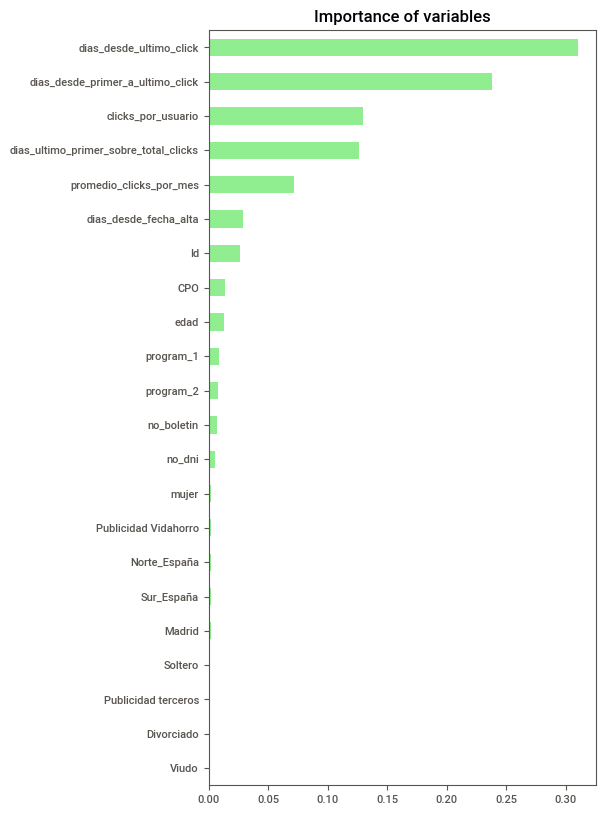

<Figure size 600x400 with 0 Axes>

In [28]:
numericas = variables_numericas()

plt.figure(figsize=(5,10))
importances=pd.Series(data=mejor_modelo.feature_importances_, index=numericas)
importances_sorted=importances.sort_values()
importances_sorted.plot(kind='barh',color='lightgreen')
plt.title('Importance of variables')
plt.show()
plt.tight_layout() 

## Parte VIII: **Aplicación con librería 'tkinter'**

Con el fin de cumplir el objetivo propuesto al inicio, se desarrolló una aplicación para que la empresa pueda actualizar los datos y obtener predicciones de los usuarios activos para el siguiente mes. A continuación, un vídeo que explica cómo funciona la aplicación.

In [29]:
HTML("""
<video width="500" height="300" controls>
  <source src="GUI_explicacion.mp4" type="video/mp4">
</video>
""")

Con el código a continuación se puede ejectuar la aplicación. Se pueden ingresar los datasets que estan en la misma carpeta del notebook.

In [30]:
class vidahorro: 

    def __init__(self, root): 

        self.root = root 
        self.file_name = '' 
        self.f = Frame(self.root) 
        
     
        # Place the frame on root window 
        self.f.pack() 
       
        # Buttons 

        self.usuarios_button = Button(self.f,
                                     text = 'Cargar archivo usuarios.xlsx',
                                     font = ('Arial', 14),
                                     bg = '#0A3787',
                                     fg = 'White',
                                     command = self.upload_usuarios)
        
        self.programas_button = Button(self.f,
                                     text = 'Cargar archivo programas.xlsx',
                                     font = ('Arial', 14),
                                     bg = '#0A3787',
                                     fg = 'White',
                                     command = self.upload_programas)
        
        self.dni_button = Button(self.f,
                                     text = 'Cargar archivo no_dni.xlsx',
                                     font = ('Arial', 14),
                                     bg = '#0A3787',
                                     fg = 'White',
                                     command = self.upload_dni)
        self.boletin_button = Button(self.f,
                                     text = 'Cargar archivo no_boletin_adhesion.xlsx',
                                     font = ('Arial', 14),
                                     bg = '#0A3787',
                                     fg = 'White',
                                     command = self.upload_boletin)
        self.clicks_button = Button(self.f, 
                                    text = 'Cargar archivo clicks.xlsx', 
                                    font = ('Arial', 14), 
                                    bg = '#0A3787', 
                                    fg = 'White', 
                                    command = self.upload_clicks)
        self.display_button = Button(self.f, 
                                    text = 'Evaluar modelo', 
                                    font = ('Arial', 14), 
                                    bg = '#B1D80F', 
                                    fg = 'Black', 
                                    command = self.evaluar)
        self.export_button = Button(self.f,
                                   text='Predecir mes',
                                   font = ('Arial', 14),
                                   bg = '#B1D80F',
                                   fg = 'Black',
                                   command = self.exportxls)
        self.exit_button = Button(self.f, 
                                text = 'Salir', 
                                font = ('Arial', 14), 
                                bg = '#B1D80F', 
                                fg = 'Black', 
                                command = root.destroy)
        
        
        # Creating label widgets - al final
        self.message_label = Label(self.f, 
                                text = 'Compra como siempre, jubílate como nunca', 
                                font = ('Times New Roman', 18, "italic"), 
                                fg = 'Black') 
    
        

        # Placing the widgets using grid manager 
        self.usuarios_button.grid(row=3, column=0,
                                 padx=10, pady=15)
        self.programas_button.grid(row=3,column=1,
                                 padx=0, pady=15)
        self.boletin_button.grid(row=3, column=2,
                                 padx=10, pady=15)
        self.dni_button.grid(row=5, column=0,
                             columnspan=2,
                             padx=10, pady=15)
        self.clicks_button.grid(row = 5, column=1,
                                columnspan=2,
                                padx = 10, pady = 15) 
        self.display_button.grid(row = 7, column = 0,
                                 sticky=W+E+N+S,
                                padx = 10, pady = 15)
        self.export_button.grid(row = 7, column = 1, 
                                sticky=W+E+N+S,
                                padx = 10, pady = 15)
        self.exit_button.grid(row = 7, column = 2, 
                              sticky=W+E+N+S,
                                padx = 10, pady = 15) 
        self.message_label.grid(row = 8, column = 1,
                               columnspan=2, sticky=E,)
        

    def upload_usuarios(self):
        
        self.file_name_usu = filedialog.askopenfilename(initialdir = '/Desktop', 
                                                        title = 'Seleccione un archivo .xlsx', 
                                                    filetypes = (('Excel file','*.xlsx'), 
                                                                ('Excel file','*.xlsx')))
        global usuarios
        usuarios = pd.read_excel(self.file_name_usu)
    def upload_programas(self):
        self.file_name_prog = filedialog.askopenfilename(initialdir = '/Desktop', 
                                                        title = 'Seleccione un archivo .xlsx', 
                                                    filetypes = (('Excel file','*.xlsx'), 
                                                                ('Excel file','*.xlsx')))
        
        
        
        global programas
        programas = pd.read_excel(self.file_name_prog)
    def upload_dni(self):
        self.file_name_dni = filedialog.askopenfilename(initialdir = '/Desktop', 
                                                        title = 'Seleccione un archivo .xlsx', 
                                                    filetypes = (('Excel file','*.xlsx'), 
                                                                ('Excel file','*.xlsx')))
            
        global no_dni
        no_dni = pd.read_excel(self.file_name_dni)
        no_dni.insert(1,'no_dni', 0)

    def upload_boletin(self):
        self.file_name_bol = filedialog.askopenfilename(initialdir = '/Desktop', 
                                                        title = 'Seleccione un archivo .xlsx', 
                                                    filetypes = (('Excel file','*.xlsx'), 
                                                                ('Excel file','*.xlsx')))
        
        global no_boletin
        no_boletin = pd.read_excel(self.file_name_bol)
        no_boletin.insert(1,'no_boletin', 0)
    def upload_clicks(self): 
        try: 
            self.file_name = filedialog.askopenfilename(initialdir = '/Desktop', 
                                                        title = 'Seleccione un archivo .csv', 
                                                    filetypes = (('Excel file','*.xlsx'), 
                                                                ('Excel file','*.xlsx')))

            global df
            df = pd.read_excel(self.file_name) 
            df = fechas(df) 

            global fecha_max
            fecha_max = max(df.fecha)
            meses = {1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}
            global dia_max
            dia_max = fecha_max.day
            global mes_max
            mes_max = fecha_max.month
            global mes_max_letra
            mes_max_letra = meses[fecha_max.month]
            global mes_resultados
            global mes_predicciones
            if dia_max >20:
                mes_resultados = mes_max
                mes_resultados_letra = mes_max_letra
                mes_predicciones = mes_max+1
                mes_predicciones_letra = meses[mes_predicciones]
            else:
                mes_resultados = mes_max-1
                mes_resultados_letra = meses[mes_resultados]
                mes_predicciones = mes_max
                mes_predicciones_letra = mes_max_letra
            msg.showinfo('Operación realizada con éxito', 'Archivo subido correctamente.\nDatos hasta {} de {} de {}.\nSe mostrarán los resultados para {} y se realizarán predicciones sobre {}.'.format(dia_max, mes_max_letra, fecha_max.year, mes_resultados_letra, mes_predicciones_letra))

        except FileNotFoundError as e: 
                msg.showerror('Error in opening file', e) 

    def evaluar(self): 
        fecha_actual = datetime.today()
        result_1=pd.merge(usuarios, programas, on='Id', how='left')
        result_2=pd.merge(result_1, no_dni, on='Id', how='left')
        result_3=pd.merge(result_2, no_boletin, on='Id', how='left')

        global result_4
        result_4 = (result_3.pipe(rename_cols)
                            .pipe(imputacion_de_valores_desconocidos)
                            .pipe(variable_sexo)
                            .pipe(estado_civil)
                            .pipe(fecha_de_alta)
                            .pipe(residencia_fiscal)
                            .pipe(calcular_edad_con_fecha_nacimiento)
                            .pipe(codigo_postal) )         


        global mes_anterior 
        mes_anterior = mes_resultados - 1
        df_mes_anterior, df_mes = (df.pipe(mes_anterior_y_mes, dataframe_demographics = result_4, mes_resultados = mes_resultados, mes_anterior = mes_anterior) )  
        X_train, X_test, y_train, y_test = train_test_split(df_mes_anterior, df_mes) 


        model=mejor_modelo.fit(X_train,y_train)  # mejor_modelo
        ypred=model.predict(X_test)
        yprobs = model.predict_proba(X_test)

        yprobs = pd.DataFrame(yprobs)
        yprobs.columns = ['Neg','Pos']

        yprobs['pred'] = yprobs['Pos']>0.5

        yprobs['pred'] = yprobs['pred'].astype('float') 
        yprobs['real'] = y_test.values
        ypred = yprobs['pred'].values
        yprobs['TN'] = (yprobs['pred']==0) &  (yprobs['real']==0)
        yprobs['TP'] = (yprobs['pred']==1) &  (yprobs['real']==1)
        yprobs['FN'] = (yprobs['pred']==0) &  (yprobs['real']==1)
        yprobs['FP'] = (yprobs['pred']==1) &  (yprobs['real']==0)

        TN = yprobs['TN'].sum()
        TP = yprobs['TP'].sum()
        FN = yprobs['FN'].sum()
        FP = yprobs['FP'].sum()
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        F1_score = 2*(Precision*Recall)/(Precision+Recall)
        msg.showinfo('Resultados del modelo','True Negatives: {}\nTrue Positives: {}\nFalse Negatives: {}\nFalse Positives: {}\nPrecision (True Positive / Total predicted positive): {}\nRecall (True Positive / Total actual positive): {}\nF1 Score: {}'.format(TN,TP,FN,FP,round(Precision,2),round(Recall,2),round(F1_score,2)))
   

    def exportxls(self): 
        mes_anterior = mes_resultados

        df_mes_anterior, df_mes = (df.pipe(mes_anterior_y_mes, dataframe_demographics = result_4, mes_resultados = mes_predicciones, mes_anterior = mes_anterior) )  
        X_train, X_test, y_train, y_test = train_test_split(df_mes_anterior, df_mes) 

        model=mejor_modelo.fit(X_train,y_train)
        ypred=model.predict(X_test)
        yprobs = model.predict_proba(X_test)
        
        #crear fichero con las probabilidades de los usuarios y sus características
        probas = pd.DataFrame({'User ID':df_mes['Id'], 'prob':model.predict_proba(X_test)[:,1], 'Sexo':df_mes['mujer'], 'Días desde último click':df_mes['dias_desde_ultimo_click'], 'Click por mes':df_mes['promedio_clicks_por_mes'], 'Cepsa (Programa 1)':df_mes['program_1'], 'Código postal':df_mes['CPO'], 'Clicks por usuarios':df_mes['clicks_por_usuario'] })
        probas = probas.sort_values(by='prob', ascending=False)
        #definir la ruta dónde gurdar
        filedialog.askdirectory()
        #definir el nombre con el que se desea guardar
        savefile = filedialog.asksaveasfilename(filetypes =(("Excel Files", "*.xlsx"),("All Files","*.*")))
        probas.to_excel(savefile + ".xlsx", index=False, sheet_name="Resultados")
        #Mensaje de descarga exitosa
        msg.showinfo('Descarga del archivo correcta','El archivo excel con las predicciones se ha descargado correctamente. Se encuentra en la carpeta que seleccionó anteriormente.')


# Driver Code 
root = tk.Tk()
root.title('Vidahorro-Procesamiento de archivos') 
root.geometry('1000x500')

logo = tk.PhotoImage(file="Logo_Vidahorro.gif")
logo = logo.zoom(25) #cambiar el tamaño
logo = logo.subsample(40) #cambiar el tamaño

logo_label = tk.Label(root, image=logo)
logo_label.pack()

obj = vidahorro(root)

root.mainloop()

## Parte IX: Conclusiones y futuro objetos de estudio.

- El uso de pipelines ahorro muchas líneas de código al realizar el procesado de nuevos datos.

- Las variables más significativas para el modelo fueron las métricas de los clicks (nº de clicks, días desde el primer al último click, etc.), mientras que las variables demográficas (sexo, estado civil, edad, etc.) resultaron ser menos importantes.

- Una interfaz gráfica permite a personas con poco experiencia en programación hacer uso del procesado y modelaje de los datos para, posteriormente, recibir en un archvio excel las predicciones de los usuarios activos. 
    - Simplemente subiendo los ficheros y pulsando los distintos botones de la interfaz.


- En el momento en el que se desarrolló esta aplicación, se disponía de datos desde principios de Enero a principios de Mayo del 2020.
Dado que estos datos son insuficientes para estudiar una posible estacionalidad en el compartamiento de los clientes a lo largo de un año, este tema se deja como objeto de estudio para futuros proyectos.



## Parte X: Anexo

- Procesamiento de las variables 'Localidad', 'Provincia' y 'Profesión'.

### 1) Profesión

- Se vuelve a crear el fichero result_4

In [31]:
result_4 = (dataframes['usuarios'].pipe(merge_datasets)
                  .pipe(rename_cols)
                  .pipe(imputacion_de_valores_desconocidos)
                  .pipe(variable_sexo)
                  .pipe(estado_civil)
                  .pipe(fecha_de_alta)
                  .pipe(residencia_fiscal)
                  .pipe(calcular_edad_con_fecha_nacimiento)
                  .pipe(codigo_postal)
           ) 

- Transformaciones:

  - Quitar tildes.
  - Identificar las palabras que no son profesiones y convertirlas a 'NaN'.
  - Convertir palabras abreviadas a nombre completro.
  - Usar listado de profesiones de internet para realizar test de similitud con la librería 'fuzzywuzzy'. De esta forma, se consigue reducir el número de categorías.
  - Remplazar profesiones que son muy parecidas (por ejemplo 'docente' y 'profesor' deben pertenecer a la misma categoría.
  - Convertir variables con poca frecuencia a 'NaN'.
  - Crear diccionario que agrupa las profesiones por sectores. 


In [32]:
# Quitar tildes
for index, fila in result_4.iterrows():
    texto = str(fila['Profesión'])
    s1 = texto.replace("ñ", "#").replace("Ñ", "%")
    s2 = unicodedata.normalize("NFKD", s1)\
     .encode("ascii","ignore").decode("ascii")\
     .replace("#", "ñ").replace("%", "Ñ")
    result_4.loc[index,"Profesión"] = s2


palabras_mal = ["madrid",".", "-", "cra", "---", "mcdonald", "ddddd", "25/12/1981", "sl", "mis labores", "aac", "liberal", "yoigo", "tf", "trelo", "otros", "tcp", "jsjsj", "prueba", "atv", "titulada", "tec prl", "675279668", "aa", "mtl", "xxx", "lade", "605669067", "ts", "cbc", "cava"]
for index, fila in result_4.iterrows():
    if fila[6] in list(palabras_mal):
        result_4.loc[index,"Profesión"] = np.nan


dic1_prof = {"adtvo":"administrativo", "adtvo.":"administrativo", "kam":"ejecutivo de cuentas", "account manager":"ejecutivo de cuentas", "admon":"administrativo", "agente once":"venta", "agente patrimonial":"consejero patrimonial", "auxiliar de servicios":"conserje", "servicios auxiliares":"conserje", "tornero":"fabrica", "ayte.tornero":"fabrica", "d.u.e":"enfermero", "due":"enfermero", "telemarketin":"marketing", "telemarketing":"marketing", "tecnico telemarketing":"marketing", "auxiliar geriatria":"geriatria", "geriatra":"geriatria", "pmo":"jefe", "hogar":"ama de casa", "uñas":"peluquero", "accounting secretary":"secretaria", "business analyst":"analista", "market research analyst":"analista", "digital analyst":"analista", "taxista":"conductor", "taxi":"conductor", "vividora":"desempleado", "en paro":"desempleado", "aux inf":"informatico", "maestra infantil":"profesor", "ninguna":"desempleado", "back office":"informatico", "office":"administrativo", "head of ai":"jefe", "d. contabilidad":"contable", "esteticien":"esteticista", "esteticiente":"esteticista", "estericien":"esteticista", "maestea":"profesor", "dependiera":"dependiente", "youtuber":"influencer", "abministratiba":"administrativo", "sin empleo":"desempleado", "hr manager":"jefe", "rrhh":"administrativo", "ceo":"jefe", "sales assistant":"venta", "cuenta ajena":"autonomo", "particular":"autonomo", "decorador":"diseñadora", "incapacidad absoluta":"pensionista", "correos":"cartero", "corredor":"deportista", "estudiar":"estudiante", "estudio":"estudiante", "estudios":"estudiante", "product manager":"jefe", "project manager":"jefe","manager":"jefe","brand manager":"jefe","sales manager":"venta","account manager":"jefe","business development manager":"jefe","it manager":"jefe","social media manager":"jefe","community manager assistant":"marketing","event manager":"relaciones","loss prevention manager":"jefe","econmerce manager":"jefe","":"jefe","area manager":"jefe", "policia local":"oficial", "emprendedores":"autonomo", "cuenta agena":"autonomo", "auxiliar cocina":"cocinero", "transportirta":"conductor", "camionero":"conductor", "tienda":"dependiente", "jefa de seccion":"jefe", "asegurador":"seguros", "moza de almacen":"dependiente", "mozo":"dependiente", "transportista":"conductor", "transportes":"conductor","transporte":"conductor", "tcae":"enfermero","tcai":"enfermero","reponedor alimentos":"dependiente", "por cuenta ajena":"autonomo","operadora":"teleoperador","mediador":"seguros","maquilladora":"esteticista","mantenimiento":"conserje","limpieza":"conserje","maesta":"profesor","jefa de equipo":"jefe","inventor":"autonomo","freelance":"autonomo","formacion":"profesor","finanzas":"financiero","envasadora":"fabrica","encargada establecimiento":"jefe","encargado":"jefe","en parp":"desempleado","encargado obras":"jefe","empleado por cuenta ajena":"autonomo","empleado industrial":"fabrica","educacion":"profesor","ecommerce":"venta","docencia":"profesor","dir. negocio":"gerente","cta ajena":"autonomo","cosmetica":"esteticista","cortes":"peluquero","coach":"entrenador","auxiliar clinica":"sanitario","admvo":"administrativo", "Encargada":"dependiente" ,"aux.clinica":"enfermero" ,"opositor":"estudiante", "agente inmobiliario":"inmobiliario","promotora":"inmobiliario","recursos humanos":"administrativo","electrónica":"informatico"}
result_4["Profesión"].replace(dic1_prof, inplace=True)

no_profesiones = pd.Series(['ama de casa', 'agente viajes', 'atencion al cliente', 'autónomo', 'Abogado', 'Académico', 'Adjunto', 'Administrativo', 'agricultor', 'Alergólogo', 'Almacenista', 'auditor', 'arbitro', 'Anestesiólogo', 'azafata', 'Antropólogo', 'actuario', 'Archivero', 'Arqueólogo', 'Arquitecto', 'Asesor', 'Asistente', 'Atleta', 'analista', 'Autor', 'Avicultor', 'Bacteriólogo', 'banca', 'bordador', 'Bibliotecario', 'bombero', 'barbero', 'Biólogo', 'Bioquímico', 'bailarina', 'Botánico', 'becario', 'comercial', 'camarero', 'consultor', 'Cardiólogo', 'Cartógrafo', 'Castrador', 'Catedrático', 'Cirujano', 'comunicacion', 'contable', 'Comadrón', 'consejero patrimonial', 'charcutera', 'Conserje', 'conductor', 'Coordinador', 'cajero', 'Cosmólogo', 'Criminalista', 'carpintero', 'chofer', 'cocinero', 'carretillero', 'controller', 'cartero', 'dependiente', 'Decano', 'Decorador', 'Defensor', 'Delegado', 'Desempleado', 'Demógrafo', 'Dentista', 'Dermatólogo', 'desarrollador', 'Directivo', 'Director', 'diseñadora', 'Doctor', 'Documentalista', 'docente', 'delineante', 'estudiante', "entrenador", 'Ecólogo', "empleado publico", 'Economista', 'Educador', 'ejecutivo de cuentas', 'Endocrinólogo', 'Enfermero', 'Enólogo', 'Entomólogo', 'Epidemiólogo', 'Especialista', 'esteticista', 'empresario', 'Estadístico', 'Etimólogo', 'electricista', 'emprendedor', 'empleada', 'Examinador', 'fabrica', 'Farmacéutico', 'Farmacólogo', 'Filólogo', 'Filósofo', 'Fiscal', 'Físico', 'frutero', 'fisioterapeuta', 'farmacia', 'financiero', 'Forense', 'Fotógrafo', 'Funcionario', 'fontanero', 'Gemólogo', 'Geobotánica', 'Geodesta', 'Geofísico', 'guardia civil', 'Geólogo', 'Geomántico', 'Geómetra', 'Geoquímica', 'Gerente', 'geriatria', 'Gerontólogo', 'Gestor', 'graduado social', 'gerocultor', 'Grafólogo', 'Gramático', 'Hematólogo', 'Hepatólogo', 'Hidrogeólogo', 'hostelero', 'Hidrólogo', 'Higienista', 'Hispanista', 'Historiador', 'Homeópata', 'Informático', 'Ingeniero', 'Inmunólogo', 'Inspector', 'inmobiliario', 'interiorista', 'Investigador', 'Jardinero', 'Jefe', 'Juez', 'jubilado', 'jefe proyecto', 'limpiadora', 'logistica', 'Licenciado', 'Lingüista', 'Logopeda', 'Marinero', 'Maestro', 'modelo', 'Matemático', 'Matrón', 'Medico', 'Meteorólogo', 'marketing', 'Microbiológico', 'masajista', 'militar', 'mozo', 'Monitor', 'moda', 'Naturópata', 'Nefrólogo', 'Neumólogo', 'Neuroanatomista', 'Neurobiólogo', 'Neurocirujano', 'niñera', 'Neurólogo', 'nutricionista', 'Oceanógrafo', 'Odontólogo', 'Oficial', 'Oficinista', 'Oftalmólogo', 'Oncólogo', 'Óptico', 'Optometrista', 'Ordenanza', 'Orientador', 'Ortopédico', 'Ortopedista', 'operario', 'Osteópata', 'Otorrinolaringólogo', 'pensionista', 'peluquero', 'pintor', 'piloto', 'Paleontólogo', 'Patólogo', 'Profesor', 'Pediatra', 'Pedicuro', 'Periodista', 'Perito', 'parado', 'pedagogo', 'Podólogo', 'Portero', 'Prehistoriador', 'Presidente', 'Proctólogo', 'Programador', 'Protésico', 'Proveedor', 'Psicoanalista', 'Psicólogo', 'Psicopedagogo', 'Psicoterapeuta', 'Psiquiatra', 'Publicista', 'peon', 'Puericultor', 'Químico', 'Quiropráctico', 'repartidor',"reponedor", 'Radiólogo', 'Radiotécnico', 'Radioterapeuta', 'recepcionista', 'Rector', 'relaciones', 'Sanitario', 'Secretaria', 'Sexólogo', 'Sismólogo', 'Sociólogo', 'seguros', 'sastre', 'supervisor', 'socorrista', 'trabajador social', 'Técnico', 'teleoperador', 'Teólogo', 'Terapeuta', 'telecomunicacion', 'trader', 'Toxicólogo', 'Traductor', 'Transcriptor', 'Traumatólogo', 'Tutor', 'Urólogo', 'Veterinario', 'Vicedecano', 'vigilante', 'Vicepresidente', 'Vicerrector', 'venta', 'Viticultor', 'vendedor', 'zapatero'])
#Se las convierte a minúscula para mejor análisis
no_profesiones = no_profesiones.str.lower()


#Quitar tildes
listado_profesiones=list()
for profesion in no_profesiones:
    s1 = profesion.replace("ñ", "#").replace("Ñ", "%")
    s2 = unicodedata.normalize("NFKD", s1)\
         .encode("ascii","ignore").decode("ascii")\
         .replace("#", "ñ").replace("%", "Ñ")
    listado_profesiones.append(s2)


#Buscar similitud - Record linkage
#Por cada categría correcta
for prof in listado_profesiones:
    #encontrar posibles coincidencias con profesiones mal escritas 
    matches = process.extract(prof, result_4["Profesión"], limit = result_4["Profesión"].shape[0])

    # Por cada posible coincidencia, coincidirlo
    for potential_match in matches:
        #Si tiene score de coincidencia alto
        if potential_match[1] >= 80:

            #Reemplazar la provincia mal escrita con la categoría correcta
            result_4.loc[result_4["Profesión"] == potential_match[0], "Profesión"] = prof


dic2_prof = {"maestro":"profesor", "pedagogo":"profesor", "vendedor":"venta", "jefe proyecto":"jefe", "docente":"profesor", "gerocultor":"geriatria", "chofer":"conductor", "parado":"desempleado", "programador":"informatico", "atleta":"deportista", "doctor":"medico", "ginecologa":"medico", "trader":"financiero", "supervisor":"jefe", "educador":"profesor","reponedor":"dependiente","nada":"desempleado", "maquinista":"fabrica","emprendedor":"autonomo", "desarrollador":"informatico"}
result_4["Profesión"].replace(dic2_prof, inplace=True)

contador = result_4["Profesión"].value_counts(dropna=False)


lista_a_na=list()
for index, value in contador.items():
    if value <=2:
        lista_a_na.append(index)



for indice, fila in result_4.iterrows():
    if fila[6] in list(lista_a_na):
        result_4.loc[indice,"Profesión"] = np.nan



#Crear una permutación aleatoria para los valores categóricos
while sum(pd.isnull(result_4["Profesión"])) >0:
    permutation = np.random.permutation(result_4["Profesión"])
    #eliminar los valores vacíos
    empty_is = np.where(permutation == "")
    permutation = np.delete(permutation, empty_is)

    #Reemplazar todos los valores vacíos por un valor aleatorio de result_4["Profesión"]
    end = len(permutation)
    result_4["Profesión"] = result_4["Profesión"].apply(lambda x: permutation[np.random.randint(end)] if pd.isnull(x) else x)



result_4['Profesión'].value_counts()[result_4['Profesión'].value_counts()>=10] #considero categorías de menos de 10 ocurrencias como poco fiables


categ_profesion = result_4['Profesión'].value_counts()[result_4['Profesión'].value_counts()>=10].index

def conversion(row):
  if row in categ_profesion:
    return row
  else:
    return 'otro'

# si no están incluidas en las categorías 'categ_profesion', son convertidas a la categoría 'otro'.
result_4['Profesión'] = result_4['Profesión'].apply(conversion)


dict_profesiones = {
    'enseñanza': ['profesor', 'vicerrector', 'tutor'],
    'banca_seguros_finanzas_consultoria': ['ejecutivo de cuentas', 'consultor', 'economista', 'seguros', 'banca',
                                          'actuario','asesor','financiero'],
    'funcionario': ['funcionario','cartero','trabajador social'],
    'salud': ['enfermero','sanitario','farmaceutico','medico','psicoanalista','psicologo','terapeuta','farmacia'],
    'administracion': ['cajero','administrativo','comercial','contable', 'gestor', 'venta', 'operario', 'gerente', 'receptionista',
                      'secretaria','auxiliar', 'conserje', 'limpiadora', 'dependiente'],
    'marketing_periodismo':['teleoperador','marketing', 'periodista'],
    'estetica': ['peluquero','esteticista'],
    'restuaracion_turismo': ['hostelero', 'agente viajes', 'cocinero', 'azajata'],
    'empresario_autonomo': ['autonomo','empresario', 'jefe'],
    'tecnico': ['abogado', 'ingeniero', 'fabrica', 'tecnico', 'conductor', 'militar', 'venta', 'informatico', 'arquitecto', 'oficial'],
    'jubilado': ['jubilado', 'pensionista'],
    'desempleado': ['desempleado'],
    'estudiante' : ['estudiante'],
    'otro':['otro']
}



reversed_dict = {}
elements = list(dict_profesiones.items())

for i in range(len(elements)):

    for j in range(len(elements[i])):

      if j == 0:
        value = elements[i][j]
      
      else: 
        if len(elements[i][j]) > 1:

          for key in elements[i][j]:

            reversed_dict[key] = value
        else:

          reversed_dict[elements[i][j][0]] = value



result_4['Profesión'] = result_4.Profesión.map(reversed_dict)


result_4['Profesión'] = result_4.Profesión.fillna('otro')
result_4.Profesión.value_counts()

administracion                        957
banca_seguros_finanzas_consultoria    701
estudiante                            472
tecnico                               461
otro                                  431
funcionario                           259
enseñanza                             238
salud                                 187
empresario_autonomo                   183
marketing_periodismo                  106
desempleado                            81
restuaracion_turismo                   70
estetica                               51
jubilado                               42
Name: Profesión, dtype: int64

- Una vez que se tiene la variables agrupada por sectores. Se procede a crear dummies.
- Para evitar multicolinearidad, se procede a eliminar la variable 'otro' porque es la que menos información proporciona.
- Como se puede, observar las dummies han sido añadidas en el fichero 'result_4'.

In [33]:
dummies_profesion = pd.get_dummies(result_4.Profesión)
dummies_profesion['Id'] = result_4.Id

dummies_profesion.drop('otro', axis=1, inplace=True) # La elimino porque es la dummy que menos información nos aporta.

result_4 = pd.merge(result_4, dummies_profesion, on='Id', how='left')
analytics(result_4)

Tipo  NAs  Valores únicos
Id                                    int64    0            4239
estado_civil                         object    0               4
F. Nacimiento                        object    0              56
CPO                                   int64    0            1712
Localidad                            object   14            1566
Provincia                            object   28             215
Profesión                            object    0              14
cod_promo                            object    0               2
Publicidad Vidahorro                  int64    0               2
Publicidad terceros                   int64    0               2
program_1                             int64    0               2
program_2                           float64    0               2
no_dni                              float64    0               2
no_boletin                          float64    0               2
mujer                                 uint8    0               2
Divorciado                            uint8    0               2
Soltero                               uint8    0               2
Viudo                                 uint8    0               2
dias_desde_fecha_alta                 int64    0             628
edad                                  int64    0              56
Madrid                                uint8    0               2
Norte_España                          uint8    0               2
Sur_España                            uint8    0               2
administracion                        uint8    0               2
banca_seguros_finanzas_consultoria    uint8    0               2
desempleado                           uint8    0               2
empresario_autonomo                   uint8    0               2
enseñanza                             uint8    0               2
estetica                              uint8    0               2
estudiante                            uint8    0               2
funcionario                           uint8    0               2
jubilado                              uint8    0               2
marketing_periodismo                  uint8    0               2
restuaracion_turismo                  uint8    0               2
salud                                 uint8    0               2
tecnico                               uint8    0               2

### 2) Localidad

- Se procede a clasificar a las poblaciones en función de su número de habitantes.

- Para ello se descarga una tabla de wikipedia donde aparecen las ciudades con más habitantes en España.

- Los poblaciones con más de un millón de habitantes son de rango 3, más de medio millón rango 2 y más de cien mil habitantes rango 1. El resto de localidades son rango 0.

In [34]:
result_4['Localidad'] = result_4['Localidad'].str.lower()

url = 'https://es.wikipedia.org/wiki/Anexo:Municipios_de_Espa%C3%B1a_por_poblaci%C3%B3n'
res = requests.get(url)
soup = BeautifulSoup(res.content,'html.parser')#lxml

all_wikitables_in_that_website = soup.find_all('table',{'class':'wikitable'})

first_wikitable = all_wikitables_in_that_website[0] 

municipalities = pd.read_html(str(first_wikitable))[0]
municipalities = municipalities.loc[:, ['Nombre', 'Población(1 de enero de 2019)']]
municipalities.columns = ['Localidad', 'Population']

def bins_pop(row):
  row = int(row.replace(' ',''))
  if row > 1000000:
    return 'very high'
  elif row > 500000:
    return 'moderate high'
  elif row > 100000:
    return 'medium'
  else:
    return 'low'

municipalities['bins_localidad'] = municipalities['Population'].apply(bins_pop)
municipalities['Localidad'] = municipalities['Localidad'].apply(lambda row: row.lower())
municipalities = municipalities.loc[:,['Localidad','bins_localidad']]
municipalities['bins_localidad'] = municipalities.bins_localidad.map({'very high': 3, 'moderate high': 2, 'medium':1})
municipalities['bins_localidad'] = municipalities['bins_localidad'].fillna(0) 

result_4=pd.merge(result_4, municipalities, on='Localidad', how='left')
result_4['bins_localidad'] = result_4.bins_localidad.fillna(0)

result_4.bins_localidad.value_counts()

0.0    2430
3.0     880
1.0     723
2.0     206
Name: bins_localidad, dtype: int64

### 3) Provincia

- Proceso similar al de la variable 'Profesión'.


In [35]:
result_4['Provincia'] = result_4['Provincia'].str.lower()

lista_provincias = pd.Series(["A Coruña","Álava","Albacete","Alicante", "Almería","Asturias", "Ávila", "Badajoz", "Barcelona", "Burgos", "Cáceres","Cádiz", "Cantabria", "Castellón", "Ciudad Real", "Córdoba", "Cuenca", "Girona", "Granada","Guadalajara","Guipúzcoa","Huelva","Huesca","Islas Baleares", "Jaén","La Rioja", "Las Palmas","León", "Lleida", "Lugo", "Madrid", "Málaga", "Murcia", "Navarra", "Ourense", "Palencia", "Pontevedra", "Salamanca","Santa Cruz de Tenerife","Segovia","Sevilla","Soria","Tarragona","Teruel","Toledo","Valencia","Valladolid","Vizcaya","Zamora","Zaragoza","Ceuta","Melilla"])
lista_provincias= lista_provincias.str.lower()

#Por cada categría correcta
for prov in lista_provincias:
    #encontrar posibles coincidencias con provincias mal escritas 
    matches = process.extract(prov, result_4["Provincia"], limit = result_4["Provincia"].shape[0])

    # Por cada posible coincidencia, coincidirlo
    for potential_match in matches:
        #Si tiene score de coincidencia alto
        if potential_match[1] >= 80:

            #Reemplazar la provincia mal escrita con la categoría correcta
            result_4.loc[result_4["Provincia"] == potential_match[0], "Provincia"] = prov


dic = {"gipuzkoa":"guipúzcoa","palma de mallorca":"islas baleares","vigo":"pontevedra", "leganes":"madrid", "monforte de lemos":"lugo", "navalcarnero":"madrid","getafe":"madrid","28055":"madrid","badalona":"barcelona","aguadulce":"almería","ames":"a coruña","bcn":"barcelona","alcala de henares":"madrid","08029":"barcelona","pozuelo de alarcon":"madrid","bilbao":"vizcaya","sahagun":"león", "palma del rio":"córdoba", "vélez blanco":"almería", "logroño":"la rioja", "buenas":"teruel", "aviles":"asturias", "08035":"barcelona", "miranda de ebro":"burgos"}

result_4["Provincia"].replace(dic, inplace=True)

dic2 = {"andalucía":"córdoba","cataluña":"barcelona"}

result_4["Provincia"].replace(dic2, inplace=True)

result_4 = result_4.replace("midlands occidentales",np.nan)


# Hay muchos na que tienen en localidad información de la provincia a la que pertenecen. Convertirlo manualmente
no_en_lista=result_4.loc[~result_4["Provincia"].isin(lista_provincias)]
no_en_lista['Localidad'] = no_en_lista['Localidad'].str.lower()


#Reemplazo los valores de localidad a provincia
dic3 = {"palma del rio":"córdoba","villalbilla":"madrid", "malaga":"málaga", "cordoba":"córdoba", "logroño":"la rioja", "puerto del carmen - tias":"las palmas", "manzanares":"ciudad real", "s. sebastian de los reyes":"madrid", "azuqueca":"guadalajara", "leon":"león"}    

for index, fila in no_en_lista.iterrows():
    for key in dic3:
        if fila[5] == key:
            result_4.loc[index,"Provincia"] = dic3[key]
            print(result_4.loc[index,"Provincia"])


#Crear una permutación aleatoria para los valores categóricos
while sum(pd.isnull(result_4["Provincia"])) >0:
    permutation = np.random.permutation(result_4["Provincia"])
    #eliminar los valores vacíos
    empty_is = np.where(permutation == "")
    permutation = np.delete(permutation, empty_is)

    #Reemplazar todos los valores vacíos por un valor aleatorio de result_4["Profesión"]
    end = len(permutation)
    result_4["Provincia"] = result_4["Provincia"].apply(lambda x: permutation[np.random.randint(end)] if pd.isnull(x) else x)

result_4.Provincia.value_counts() 

madrid                    1382
barcelona                  345
valencia                   250
alicante                   147
sevilla                    146
málaga                     116
murcia                     103
a coruña                    88
asturias                    87
cádiz                       86
islas baleares              79
las palmas                  77
pontevedra                  77
córdoba                     75
vizcaya                     71
zaragoza                    69
guipúzcoa                   64
granada                     60
badajoz                     55
almería                     50
cantabria                   49
toledo                      49
santa cruz de tenerife      45
girona                      45
navarra                     45
tarragona                   44
bizkaia                     43
valladolid                  42
burgos                      42
castellón                   39
jaén                        37
salamanca                   32
cáceres 

### 4) Probamos la importancia de estas variables para el modelo ganador.

- Como se puede observar el sector de trabajo, el tamaño poblacional de la localidad de residencia y la provincia no son significativas para el modelo.

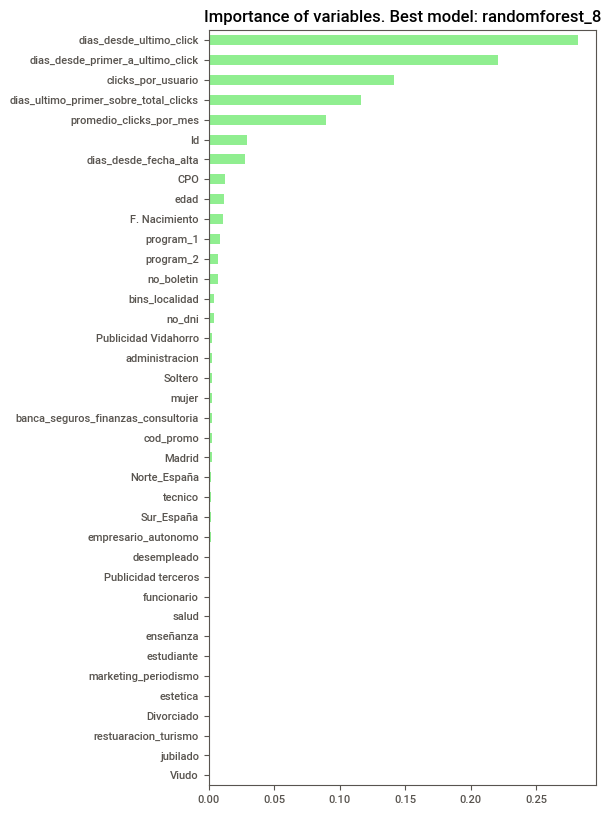

<Figure size 600x400 with 0 Axes>

In [36]:
train, test = (dataframes['clicks'].pipe(fechas)
                                   .pipe(mes_anterior_y_mes, dataframe_demographics = result_4)
) 


X_train, X_test, y_train, y_test = train_test_split(train, test) 

df_modelos, pipeline_modelos = comparacion_de_modelos(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test) 
mejor_modelo = pipeline_modelos[df_modelos.model[0]][1]



# Visualización
if len(re.findall(r'log_reg', df_modelos.model[0])) > 0:

  numericas = variables_numericas()

  plt.figure(figsize=(5,10))
  importances=pd.Series(data=abs(mejor_modelo.coef_[0]), index=numericas)
  importances_sorted=importances.sort_values()
  importances_sorted.plot(kind='barh',color='lightgreen')
  plt.title('Importance of variables. Best model: '+ df_modelos.model[0])
  plt.show()
  plt.tight_layout()



if len(re.findall(r'randomforest', df_modelos.model[0])) > 0:

  numericas = variables_numericas()
  
  plt.figure(figsize=(5,10))
  importances=pd.Series(data=mejor_modelo.feature_importances_, index=numericas)
  importances_sorted=importances.sort_values()
  importances_sorted.plot(kind='barh',color='lightgreen')
  plt.title('Importance of variables. Best model: '+ df_modelos.model[0])
  plt.show()
  plt.tight_layout()

## Este es el final. ¡Muchas gracias!